In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.layers.core import Activation, Flatten, Dropout, Dense
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import livelossplot

Cargamos el dataset creado con todos los frames

In [145]:
kitchenware = pickle.load(open('/content/drive/My Drive/Proyecto/dataset/training_dataset_2.pkl', 'rb'))
kitchenware.values.shape

(17644, 3)

In [146]:
kitchenware.head()

,label,image,path
0,ruido,"[[[91, 148, 193], [103, 159, 206], [108, 164, ...",../../INPUT/images/ruido/ruido201.jpg
1,ruido,"[[[249, 254, 255], [250, 255, 255], [237, 242,...",../../INPUT/images/ruido/ruido979.jpg
2,ruido,"[[[7, 2, 1], [5, 0, 0], [5, 1, 0], [6, 2, 1], ...",../../INPUT/images/ruido/ruido884.jpg
3,ruido,"[[[218, 219, 210], [218, 217, 207], [223, 221,...",../../INPUT/images/ruido/ruido1027.jpg
4,ruido,"[[[26, 25, 34], [33, 33, 39], [28, 28, 34], [1...",../../INPUT/images/ruido/ruido530.jpg


Haces un dummies de las etiquetas para crear un vector y obtener así el porcentaje de prediccióón por objeto

In [0]:
dummies = pd.get_dummies(kitchenware['label'])

In [148]:
dummies.head()

,cuchara,cuchillo,cuenco,hervidor,pelador,ruido,sarten,taza,tenedor,tostadora
0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0


In [0]:
dummies['gt'] = dummies.apply(lambda x: pd.Series([x.values]), axis=1)

In [150]:
dummies.head()

,cuchara,cuchillo,cuenco,hervidor,pelador,ruido,sarten,taza,tenedor,tostadora,gt
0,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
1,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
2,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
3,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
4,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"


Asignamos las variables a X e y para entrenar al modelo

In [0]:
X = np.stack(kitchenware['image'])
y = np.stack(dummies['gt'])

In [237]:
print(X.shape)
print(y.shape)

(17644, 64, 64, 3)
(17644, 10)


Dividimos los datos en train y test

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [239]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14115, 64, 64, 3)
(3529, 64, 64, 3)
(14115, 10)
(3529, 10)


Ajustamos los datos de las X (frame arrays)

In [240]:
# Incoming data is in uint8. Cast the input data images to be floats in range [0.0-1.0]  
X_train = X_train.reshape((X_train.shape[0],64,64,3))
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape((X_test.shape[0],64,64,3))
X_test = X_test.astype('float32') / 255

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

x_train shape: (14115, 64, 64, 3)
14115 train samples
3529 test samples
(14115, 64, 64, 3)
(3529, 64, 64, 3)
(14115, 10)
(3529, 10)


Definimos el modelo

In [258]:
#CNN type

num_classes = 10

model = Sequential()
chanDim = -1

if K.image_data_format() == "channels_first":
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same", input_shape=X_train.shape[1:]))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation("softmax"))

model.summary()

# CNN params
plot_losses = livelossplot.PlotLossesKeras()

EPOCHS = 18
BATCH_SIZE = 32
INIT_LR = 1e-3
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

#Training the model

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', 
              metrics=['accuracy'])

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_48 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
activation_49 (Activation)   (None, 21, 21, 64)      

Entrenamos el modelo

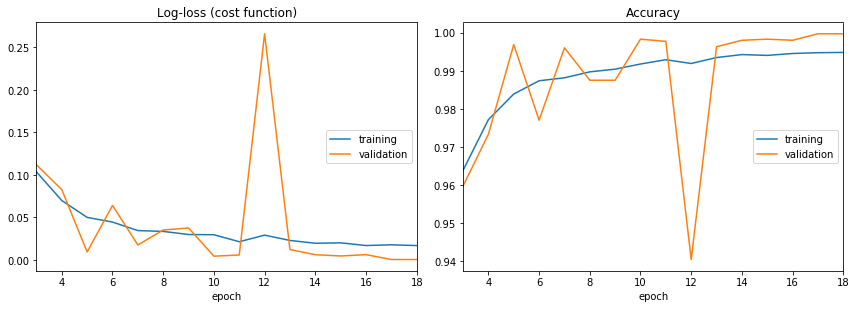

Log-loss (cost function):
training   (min:    0.017, max:    0.766, cur:    0.017)
validation (min:    0.000, max:    8.369, cur:    0.000)

Accuracy:
training   (min:    0.765, max:    0.995, cur:    0.995)
validation (min:    0.286, max:    1.000, cur:    1.000)


In [259]:
model.fit(X_train, y_train,
    batch_size=BATCH_SIZE,              
    epochs=EPOCHS,
    callbacks=[plot_losses],
    verbose=1,
    validation_data=(X_test, y_test))

Sacamos la pérdida y accuracy del modelo entrenada

In [260]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0004676735412170776
Test accuracy: 0.9997166336072542


Guardamos el modelo entrenado

In [0]:
from keras.models import load_model 
model.save('tercer_intento.h5')

In [0]:
import json
model_json = model.to_json()
with open("tercer_intento2.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("tercer_intento2.h5")

Hacemos una predicción sobre el test para ver qué tal predice

In [0]:
Y_pred = model.predict(X_test)

[4 6 0 ... 7 9 4]
[4 6 0 ... 7 9 4]


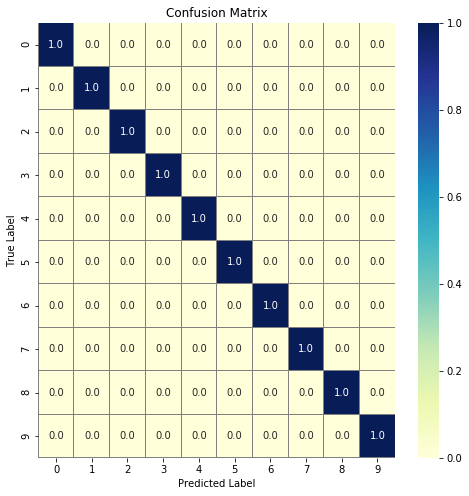

In [262]:
import matplotlib.pyplot as plt
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
print(Y_pred_classes)
Y_true = np.argmax(y_test,axis = 1)
print(Y_true)
# compute the confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="YlGnBu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show();

Creamos lista con las etiquetas para mostrar el porcentaje de predicción sobre cada objeto según el índice del vector. Hacemos una predicción sobre una foto aleatoria del test.

In [0]:
class_names = list(dummies.columns)[:-1]

[3.8284801e-12 7.6604829e-16 6.5536319e-09 3.4312171e-09 1.7564339e-08
 3.7321066e-11 1.0000000e+00 1.3779839e-15 1.6932060e-13 7.4069447e-16]
cuchara: 0.0
cuchillo: 0.0
cuenco: 0.0
hervidor: 0.0
pelador: 0.0
ruido: 0.0
sarten: 1.0
taza: 0.0
tenedor: 0.0
tostadora: 0.0
(1, 64, 64, 3)


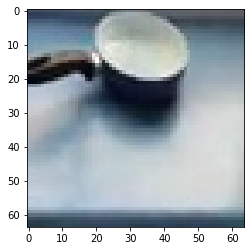

In [264]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

img = X_test[150]
pred = model.predict(np.expand_dims(img,axis=0))[0]
print(pred)
for obj in class_names:
    print(f'{obj}: {round(pred[class_names.index(obj)],5)}')
print(np.expand_dims(img,axis=0).shape)
plt.imshow(img);

A continuación realizamos pruebas sobre nuevas fotos para comprobar que no existe overfitting. Preparamos la foto según las características necesarias y realizamos la predicción.

PRUEBA 1:

In [0]:
prueba1 = cv2.imread('/content/drive/My Drive/Proyecto/dataset/new_data/cuchara.jpg')
prueba1 = cv2.resize(prueba1,(64,64))
prueba1 = prueba1.astype('float32') / 255

[1.6013288e-13 1.7348503e-10 2.9725602e-16 1.1995396e-23 8.0894225e-22
 4.4631531e-11 2.2845717e-13 3.7121239e-10 1.0924515e-12 1.0000000e+00]
cuchara: 0.0
cuchillo: 0.0
cuenco: 0.0
hervidor: 0.0
pelador: 0.0
ruido: 0.0
sarten: 0.0
taza: 0.0
tenedor: 0.0
tostadora: 1.0
(1, 64, 64, 3)


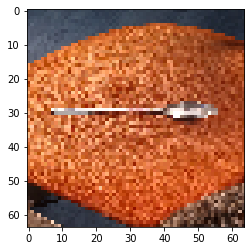

In [276]:
%matplotlib inline

img = prueba1
pred = model.predict(np.expand_dims(img,axis=0))[0]
print(pred)
for obj in class_names:
    print(f'{obj}: {round(pred[class_names.index(obj)],5)}')
print(np.expand_dims(img,axis=0).shape)
plt.imshow(img);

PRUEBA 2:

In [0]:
prueba2 = cv2.imread('/content/drive/My Drive/Proyecto/dataset/new_data/cuchillo.jpg')
prueba2 = cv2.resize(prueba2,(64,64))
prueba2 = prueba2.astype('float32') / 255

[8.4622764e-07 2.2890233e-03 5.9371610e-04 9.2205447e-08 4.8310079e-07
 3.8217628e-01 6.0193849e-01 8.9471563e-05 1.2910137e-02 1.4621544e-06]
cuchara: 0.0
cuchillo: 0.0022899999748915434
cuenco: 0.000590000010561198
hervidor: 0.0
pelador: 0.0
ruido: 0.38218000531196594
sarten: 0.6019399762153625
taza: 9.000000136438757e-05
tenedor: 0.012910000048577785
tostadora: 0.0
(1, 64, 64, 3)


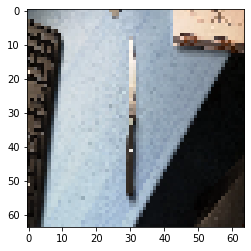

In [278]:
img = prueba2
pred = model.predict(np.expand_dims(img,axis=0))[0]
print(pred)
for obj in class_names:
    print(f'{obj}: {round(pred[class_names.index(obj)],5)}')
print(np.expand_dims(img,axis=0).shape)
plt.imshow(img);

PRUEBA 3:

In [0]:
prueba3 = cv2.imread('/content/drive/My Drive/Proyecto/dataset/new_data/cuenco.jpg')
prueba3 = cv2.resize(prueba3,(64,64))
prueba3 = prueba3.astype('float32') / 255

[3.0199971e-02 1.1917404e-06 8.6917549e-01 1.2660840e-05 2.6491869e-09
 5.4140482e-02 3.3194654e-02 1.9965603e-08 1.7873557e-05 1.3257722e-02]
cuchara: 0.03020000085234642
cuchillo: 0.0
cuenco: 0.8691800236701965
hervidor: 9.999999747378752e-06
pelador: 0.0
ruido: 0.05414000153541565
sarten: 0.03319000080227852
taza: 0.0
tenedor: 1.9999999494757503e-05
tostadora: 0.013260000385344028
(1, 64, 64, 3)


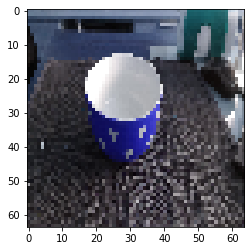

In [280]:
img = prueba3
pred = model.predict(np.expand_dims(img,axis=0))[0]
print(pred)
for obj in class_names:
    print(f'{obj}: {round(pred[class_names.index(obj)],5)}')
print(np.expand_dims(img,axis=0).shape)
plt.imshow(img);

PRUEBA 4:

In [0]:
prueba4 = cv2.imread('/content/drive/My Drive/Proyecto/dataset/new_data/cuenco2.jpg')
prueba4 = cv2.resize(prueba4,(64,64))
prueba4 = prueba4.astype('float32') / 255

[2.1818440e-08 1.2079777e-08 1.6850528e-01 4.2196039e-06 2.7850155e-07
 6.0828556e-06 1.8198150e-06 8.3148229e-01 3.7734762e-09 1.2656117e-08]
cuchara: 0.0
cuchillo: 0.0
cuenco: 0.16851000487804413
hervidor: 0.0
pelador: 0.0
ruido: 9.999999747378752e-06
sarten: 0.0
taza: 0.8314800262451172
tenedor: 0.0
tostadora: 0.0
(1, 64, 64, 3)


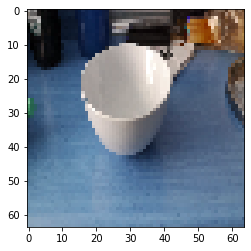

In [282]:
img = prueba4
pred = model.predict(np.expand_dims(img,axis=0))[0]
print(pred)
for obj in class_names:
    print(f'{obj}: {round(pred[class_names.index(obj)],5)}')
print(np.expand_dims(img,axis=0).shape)
plt.imshow(img);

PRUEBA 5:

In [0]:
prueba5 = cv2.imread('/content/drive/My Drive/Proyecto/dataset/new_data/pelador.jpg')
prueba5 = cv2.resize(prueba5,(64,64))
prueba5 = prueba5.astype('float32') / 255

[9.8461086e-01 4.0363197e-09 5.7640087e-10 1.7497932e-04 8.8526242e-05
 2.2034702e-07 5.7994146e-03 1.0457749e-03 2.1893826e-04 8.0612823e-03]
cuchara: 0.9846100211143494
cuchillo: 0.0
cuenco: 0.0
hervidor: 0.00016999999934341758
pelador: 9.000000136438757e-05
ruido: 0.0
sarten: 0.005799999926239252
taza: 0.0010499999625608325
tenedor: 0.00022000000171829015
tostadora: 0.008059999905526638
(1, 64, 64, 3)


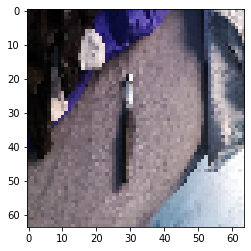

In [284]:
img = prueba5
pred = model.predict(np.expand_dims(img,axis=0))[0]
print(pred)
for obj in class_names:
    print(f'{obj}: {round(pred[class_names.index(obj)],5)}')
print(np.expand_dims(img,axis=0).shape)
plt.imshow(img);